In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from neural_exploration import *
sns.set()

### MDP settings

In [2]:
H = 6
n_states = 5
n_actions = 2
n_features = 16

noise_std = 0.0

n_episodes = int(1e3)
n_sim = 3

reg_factor = 5.0

### NeuralUCB-VI on a Linear MDP

In [3]:
a = np.random.randn(n_features)
a /= np.linalg.norm(a, ord=2)
reward_func = lambda x: np.dot(x, a)

mdp = MDPFeatures(H,
                  n_states=n_states,
                  n_actions=n_actions,
                  n_features=n_features,
                  reward_func=reward_func,
                  noise_std=noise_std,
                 )

# to check that backward induction works
mdp.sanity_policy()

In [4]:
regrets = np.empty((n_sim, n_episodes))

for i in range(n_sim):
    mdp.reset_rewards()
    model = NeuralUCBVI(mdp,
                        hidden_size=64,
                        n_episodes=n_episodes,
                        init_state=0,
                        reg_factor=reg_factor,
                        confidence_scaling_factor=1,
                        learning_rate=0.01,
                        epochs=5,
                       )
    model.run()
    regrets[i] = np.cumsum(model.regrets)

  0%|          | 0/1000 [00:00<?, ?it/s, total regret=0.224]/home/sauxpa/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 1000/1000 [01:42<00:00,  9.73it/s, total regret=26] 


### Sublinear regret growth : exploration is efficient, the optimal policy is closely approximated.

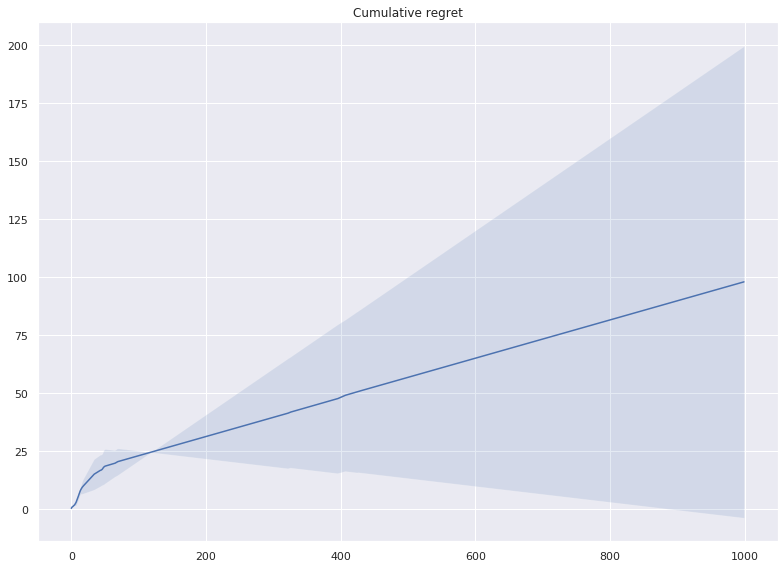

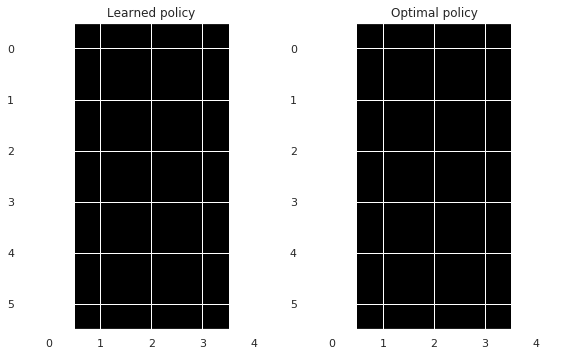

In [5]:
fig, ax = plt.subplots(figsize=(11, 8), nrows=1, ncols=1)

t = np.arange(n_episodes)
mean_regrets = np.mean(regrets[1:], axis=0)
std_regrets = np.std(regrets[1:], axis=0) / np.sqrt(regrets[1:].shape[0])
ax.plot(mean_regrets)
ax.fill_between(t, mean_regrets - 2*std_regrets, mean_regrets + 2*std_regrets, alpha=0.15)
ax.set_title('Cumulative regret')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(figsize=(8, 8), nrows=1, ncols=2)

ax = axes[0]
ax.imshow(model.policy, cmap='gray', vmin=0, vmax=mdp.n_actions-1)
ax.set_title('Learned policy')

ax = axes[1]
ax.imshow(model.pi_star, cmap='gray', vmin=0, vmax=mdp.n_actions-1)
ax.set_title('Optimal policy')

plt.tight_layout()
plt.show()

# fig.savefig('neural_ucbvi_linear.eps')

### LinUCB-VI on a Linear transition/quadratic reward MDP

In [6]:
a = np.random.randn(n_features)
a /= np.linalg.norm(a, ord=2)
reward_func = lambda x: np.dot(x, a)**2

mdp = MDPFeatures(H,
                  n_states=n_states,
                  n_actions=n_actions,
                  n_features=n_features,
                  reward_func=reward_func,
                  noise_std=noise_std,
                 )

# to check that backward induction works
mdp.sanity_policy()

In [7]:
regrets = np.empty((n_sim, n_episodes))

for i in range(n_sim):
    mdp.reset_rewards()
    model = NeuralUCBVI(mdp,
                        hidden_size=20,
                        n_episodes=n_episodes,
                        init_state=0,
                        reg_factor=reg_factor,
                        confidence_scaling_factor=1,
                        learning_rate=0.01,
                        epochs=2,
                       )
    model.run()
    regrets[i] = np.cumsum(model.regrets)

100%|██████████| 1000/1000 [00:38<00:00, 26.13it/s, total regret=80.3]


### Still sublinear growth : linear predictors yield a close enough approximation of the rewards so that the optimal policy is chosen most of the time.

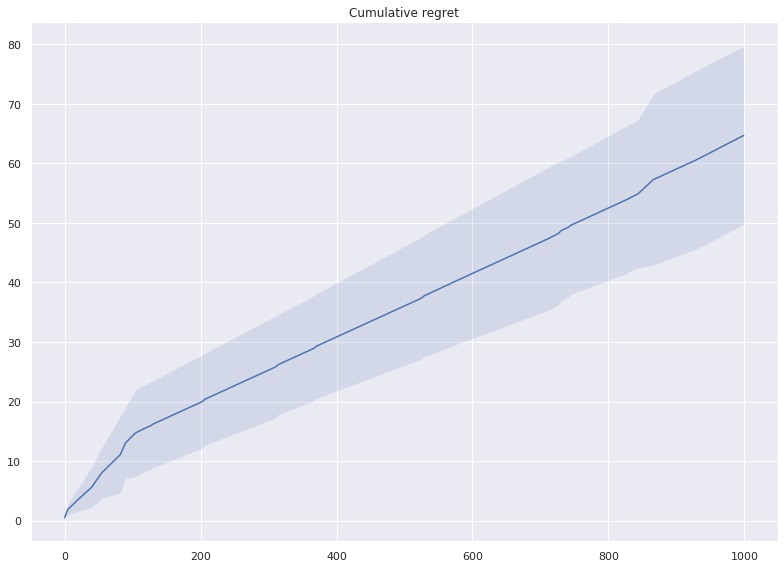

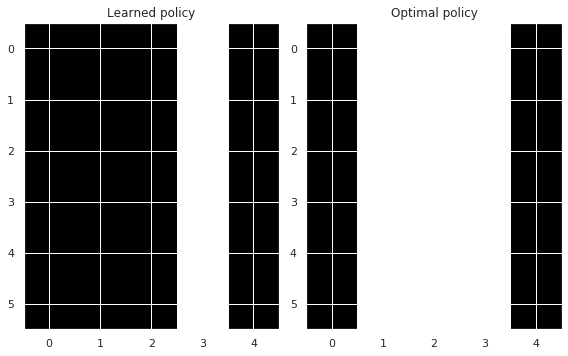

In [8]:
fig, ax = plt.subplots(figsize=(11, 8), nrows=1, ncols=1)

t = np.arange(n_episodes)
mean_regrets = np.mean(regrets, axis=0)
std_regrets = np.std(regrets, axis=0) / np.sqrt(regrets.shape[0])
ax.plot(mean_regrets)
ax.fill_between(t, mean_regrets - 2*std_regrets, mean_regrets + 2*std_regrets, alpha=0.15)
ax.set_title('Cumulative regret')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(figsize=(8, 8), nrows=1, ncols=2)

ax = axes[0]
ax.imshow(model.policy, cmap='gray', vmin=0, vmax=mdp.n_actions-1)
ax.set_title('Learned policy')

ax = axes[1]
ax.imshow(model.pi_star, cmap='gray', vmin=0, vmax=mdp.n_actions-1)
ax.set_title('Optimal policy')

plt.tight_layout()
plt.show()

# fig.savefig('neural_ucbvi_quad.eps')

### LinUCB-VI on a Linear transition/nonlinear reward MDP

In [9]:
a = np.random.randn(n_features)
a /= np.linalg.norm(a, ord=2)
reward_func = lambda x: np.cos(10*np.pi*np.dot(x, a))

mdp = MDPFeatures(H,
                  n_states=n_states,
                  n_actions=n_actions,
                  n_features=n_features,
                  reward_func=reward_func,
                  noise_std=noise_std,
                 )

# to check that backward induction works
mdp.sanity_policy()

In [10]:
regrets = np.empty((n_sim, n_episodes))

for i in range(n_sim):
    mdp.reset_rewards()
    model = NeuralUCBVI(mdp,
                        hidden_size=20,
                        n_episodes=n_episodes,
                        init_state=0,
                        reg_factor=reg_factor,
                        confidence_scaling_factor=1,
                        learning_rate=0.01,
                        epochs=2,
                       )
    model.run()
    regrets[i] = np.cumsum(model.regrets)

100%|██████████| 1000/1000 [00:35<00:00, 28.02it/s, total regret=68.9]


### Linear regret growth, reward is now "too nonlinear" for LinUCB-VI to be relevant.

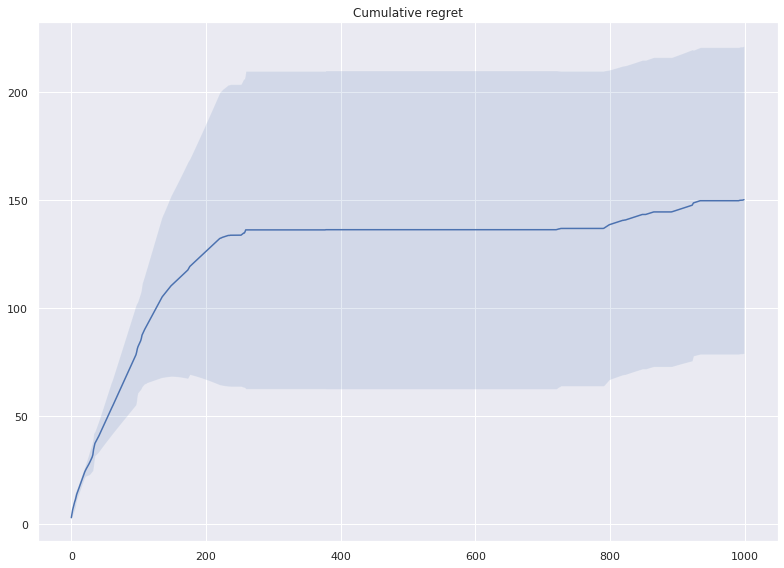

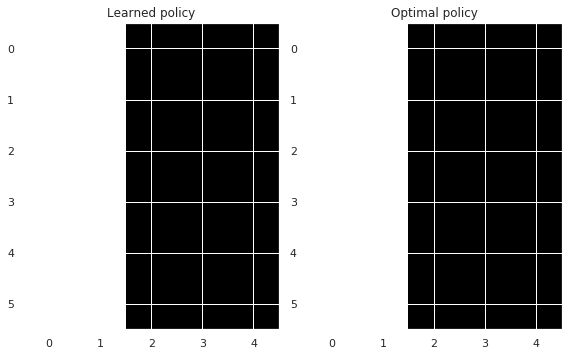

In [15]:
fig, ax = plt.subplots(figsize=(11, 8), nrows=1, ncols=1)

t = np.arange(n_episodes)
mean_regrets = np.mean(regrets, axis=0)
std_regrets = np.std(regrets, axis=0) / np.sqrt(regrets.shape[0])
ax.plot(mean_regrets)
ax.fill_between(t, mean_regrets - 2*std_regrets, mean_regrets + 2*std_regrets, alpha=0.15)
ax.set_title('Cumulative regret')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(figsize=(8, 8), nrows=1, ncols=2)

ax = axes[0]
ax.imshow(model.policy, cmap='gray', vmin=0, vmax=mdp.n_actions-1)
ax.set_title('Learned policy')

ax = axes[1]
ax.imshow(model.pi_star, cmap='gray', vmin=0, vmax=mdp.n_actions-1)
ax.set_title('Optimal policy')

plt.tight_layout()
plt.show()

# fig.savefig('neural_ucbvi_cosine.eps')